**Visualize Data**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#read dataset
df = pd.read_csv('winequality-red.csv')
df['quality'] = df['quality'].astype(float)

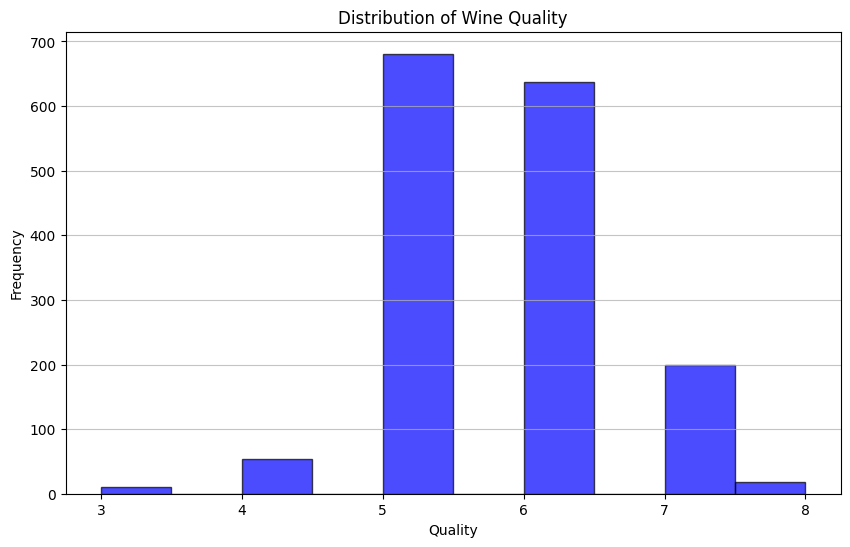

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df.get('quality'), bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.xticks(np.arange(3, 9, 1))  # Quality usually ranges from 3 to 8
plt.grid(axis='y', alpha=0.75)
plt.show()

In [10]:
#split dataset to train set and test set
from sklearn.model_selection import train_test_split
X = df.drop('quality', axis=1)      
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Random Forest**

In [15]:
class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Feature index
        self.threshold = threshold  # Threshold value
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Value for leaf nodes

In [16]:
class DecisionTreeRegression:
    def __init__(self, X, y, max_depth=None):
        self.max_depth = max_depth
        self.root = self.build_tree(X, y)
    
    def calculate_info_gain(self, y, y_left, y_right):
        total_variance = np.var(y) * len(y)
        left_variance = np.var(y_left) * len(y_left)
        right_variance = np.var(y_right) * len(y_right)
        info_gain = total_variance - (left_variance + right_variance)
        return info_gain
    
    def best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_samples, n_features = X.shape
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold
                
                if np.any(left_indices) and np.any(right_indices):
                    y_left = y[left_indices]
                    y_right = y[right_indices]
                    gain = self.calculate_info_gain(y, y_left, y_right)
                    
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = threshold
        
        return best_feature, best_threshold
    
    def split(self, X, y, feature, threshold):
        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold
        
        left_node = Node(feature=feature, threshold=threshold)
        right_node = Node(feature=feature, threshold=threshold)
        
        left_node.value = np.mean(y[left_indices])
        right_node.value = np.mean(y[right_indices])
        
        return left_indices, right_indices

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            leaf_node = Node(value=np.mean(y))
            print(f"🌳 Leaf node at depth {depth}: Predict {leaf_node.value:.4f}")
            return leaf_node

        best_feature, best_threshold = self.best_split(X, y)

        left_indices, right_indices = self.split(X, y, best_feature, best_threshold)
        x_left = X[left_indices]
        y_left = y[left_indices]
        x_right = X[right_indices]
        y_right = y[right_indices]

        left_node = self.build_tree(x_left, y_left, depth + 1)
        right_node = self.build_tree(x_right, y_right, depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_node, right=right_node)
    
    def predict(self, X):
        predictions = []
        for i, sample in enumerate(X):
            node = self.root
            depth = 0
            while node.value is None:
                indent = "  " * depth
                if sample[node.feature] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
                depth += 1
            predictions.append(node.value)
        return np.array(predictions)

In [17]:
class RandomForestRegression:
    def __init__(self, n_estimators=100, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            tree = DecisionTreeRegression(X_sample, y_sample, max_depth=self.max_depth)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.trees)))
        for i, tree in enumerate(self.trees):
            predictions[:, i] = tree.predict(X)
        return np.mean(predictions, axis=1)

In [30]:
random_forest = RandomForestRegression(n_estimators=100, max_depth=20)
random_forest.fit(X_train.values, y_train.values)
y_pred = random_forest.predict(X_test.values)

🌳 Leaf node at depth 6: Predict 6.0000
🌳 Leaf node at depth 10: Predict 5.0000
🌳 Leaf node at depth 10: Predict 4.0000
🌳 Leaf node at depth 10: Predict 5.0000
🌳 Leaf node at depth 11: Predict 6.0000
🌳 Leaf node at depth 11: Predict 5.0000
🌳 Leaf node at depth 8: Predict 4.0000
🌳 Leaf node at depth 9: Predict 6.0000
🌳 Leaf node at depth 9: Predict 5.0000
🌳 Leaf node at depth 10: Predict 6.0000
🌳 Leaf node at depth 10: Predict 5.0000
🌳 Leaf node at depth 9: Predict 5.0000
🌳 Leaf node at depth 9: Predict 5.0000
🌳 Leaf node at depth 9: Predict 6.0000
🌳 Leaf node at depth 8: Predict 6.0000
🌳 Leaf node at depth 8: Predict 5.0000
🌳 Leaf node at depth 8: Predict 6.0000
🌳 Leaf node at depth 6: Predict 5.0000
🌳 Leaf node at depth 8: Predict 5.0000
🌳 Leaf node at depth 8: Predict 6.0000
🌳 Leaf node at depth 8: Predict 7.0000
🌳 Leaf node at depth 8: Predict 6.0000
🌳 Leaf node at depth 6: Predict 5.0000
🌳 Leaf node at depth 9: Predict 5.0000
🌳 Leaf node at depth 9: Predict 6.0000
🌳 Leaf node at dep

In [31]:
#calculate errors
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
abs_error = np.mean(np.abs(y_test - y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {abs_error:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.3124
Mean Absolute Error: 0.4285
R² Score: 0.5220


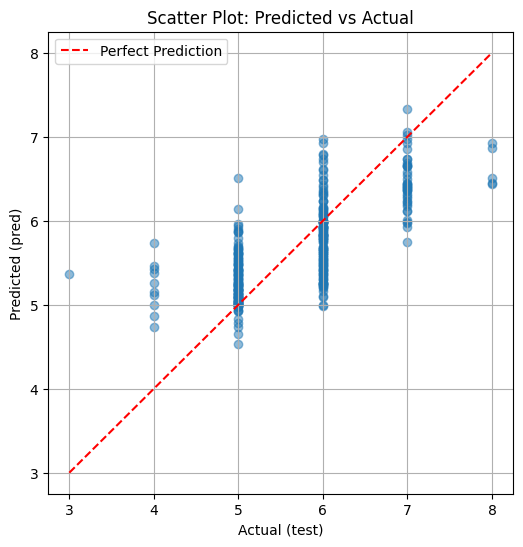

In [32]:
import matplotlib.pyplot as plt
test = y_test.values
pred = y_pred
plt.figure(figsize=(6, 6))
plt.scatter(test, pred, alpha=0.5)
plt.plot([min(test), max(test)], [min(test), max(test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual (test)')
plt.ylabel('Predicted (pred)')
plt.title('Scatter Plot: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()


**Sklearn Random Forest**

In [33]:
from sklearn.ensemble import RandomForestRegressor
sklearn_rf = RandomForestRegressor(n_estimators=100, max_depth=19, random_state=42)
sklearn_rf.fit(X_train, y_train)
y_sklearn_pred = sklearn_rf.predict(X_test)

In [34]:
#calculate errors
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_sklearn_pred)
abs_error = np.mean(np.abs(y_test - y_sklearn_pred))
r2 = r2_score(y_test, y_sklearn_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {abs_error:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.3006
Mean Absolute Error: 0.4218
R² Score: 0.5400


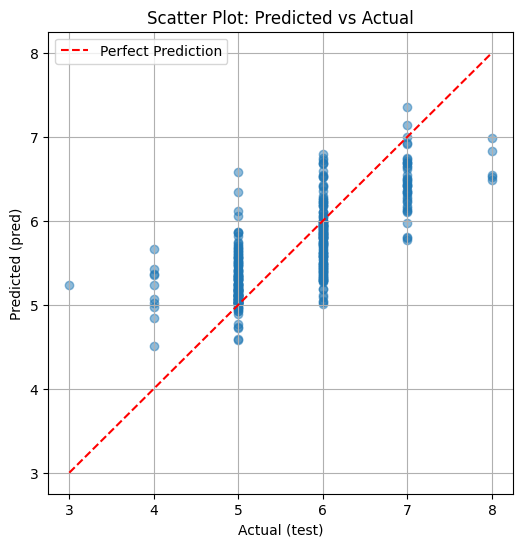

In [35]:
import matplotlib.pyplot as plt
test = y_test.values
pred = y_sklearn_pred
plt.figure(figsize=(6, 6))
plt.scatter(test, pred, alpha=0.5)
plt.plot([min(test), max(test)], [min(test), max(test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual (test)')
plt.ylabel('Predicted (pred)')
plt.title('Scatter Plot: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()
